In [18]:
from robot import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
plt.rcParams['figure.figsize'] = [10, 10]
jtplot.style(theme='chesterish')
mpl.style.use('seaborn')
from mpl_toolkits import mplot3d

import numpy as np
import quaternion
import scipy
import time

# Defining Robot
Waifu = Robot('mdh')
Waifu.robot_init()

class stateVector:
    def __init__(self):
        self.x = np.zeros(6)
        self.xd = np.zeros(6)
        self.xdd = np.zeros(6)
        self.quat = np.quaternion(1,0,0,0)
        self.quat_d = np.quaternion(1,0,0,0)
        self.quat_dd = np.quaternion(1,0,0,0)
        self.x3 = self.x[:3]
        self.xd3 = self.x[:3]
        self.xdd3 = self.x[:3]
        
class jointStateVector:
    def __init__(self, q, qd, qdd):
        self.q = q
        self.qd = qd
        self.qdd = qdd
        self.qnull = self.q
        self.qdnull = self.qd
        self.qddnull = self.qdd

class dataCollect:
    def __init__(self, sampcol):
        self.x = np.zeros((6,sampcol))
        self.xd = np.zeros((6,sampcol))
        self.q = np.zeros([7,1])
        self.qd = np.zeros([7,1])
        self.qdd = np.zeros([7,1])
        self.aq = np.zeros((7,sampcol))
        self.error  = np.zeros((6,sampcol))
        self.imp = np.zeros((6,sampcol))
        self.F  = np.zeros((7,sampcol))
        self.tau  = np.zeros((7,sampcol))
        

class simulation:
    def __init__(self, state_des, state_end, jointState, error, data):
        self.state_des = state_des
        self.state_end = state_end
        self.jointState = jointState
        self.error = error
        self.data = data
        self.Bn = np.zeros((7,7))
        self.Kn = np.zeros((7,7))
        
    def spong_impedance_control(self, impctrl, rb):
        # Double integrator impedance control strategy
        kine = rb.forwardKinematics(self.jointState.q)
        rot = kine.R
        Ko =  rot.dot(impctrl.Kd[3:, 3:]) 
        Kd_b = block_diag(impctrl.Kd[:3,:3], Ko)
        Bd = impctrl.damping_constant_mass()
        ax = impctrl.outputquat(Kd_b, Bd, self.error.x, self.error.xd, self.state_des.xdd, impctrl.F)
        aq_in = rb.calcQddNull(ax, self.jointState.q, self.jointState.qd, 
                               self.jointState.qddnull)

        # Inverse dynamics
        tauc = rb.inverseDynamics(self.jointState.q, self.jointState.qd, aq_in, rb.grav)

        # Computing Jacobian for external forces:
        J = rb.calcJac(self.jointState.q)
        Jpinv = rb.pinv(J)
        
        # Nullspace torque (projection matrix * torque_0)
        tau_nullspace = np.dot((np.eye(7) - np.dot(J.T, Jpinv.T) ), 
                                   (np.dot( impctrl.nullspace_stiffness_, (self.jointState.qnull - self.jointState.q)) - 
                                    np.dot(np.dot(2, np.sqrt(impctrl.nullspace_stiffness_)), self.jointState.qd)))    

        # q_null update
        self.jointState.q_null = self.jointState.q
        
        # Torque collected
        tau = tauc + tau_nullspace 
        return tau
        
    def classical_impedance_control(self, impctrl, rb, ndof, *args):
        # Frame Selection
        kine = rb.forwardKinematics(self.jointState.q)
        rot = kine.R
        R_e = block_diag(rot, rot)
        
        # Frame variables
        vd_error = rb.calcVd(self.jointState.q, self.jointState.qd, self.state_des.xd)
        xdd_in = R_e.dot(self.state_des.xdd)
        xd_end = R_e.dot(self.state_end.xd)

        if args:
            rb.ndof = 7
            if args[0].lower() in ['rpy']:
                J = rb.calcJac(qin)
                Ja = rb.analyticJacobian(J, self.state_end.x[3:], 'rpy')
                # Fix for jacobian dot later
                
            if args[0].lower() in ['quaternion']:
                J = rb.calcJac(self.jointState.q)
                Jd = rb.calcJacDot(self.jointState.q, self.jointState.qd)
                Ja = R_e.dot(J)
                Jad = R_e.dot(Jd)
        
        # Cartesian Inertia Matrix
#         M = rb.inertiaComp(self.jointState.q)
        Lambda = rb.cinertiaComp(self.jointState.q, Ja)
            
        # Cartesian Coriolis Matrix
        mu = rb.ccoriolisComp(self.jointState.q, self.jointState.qd, Ja, Jad)        
                
        # For the classical impedance controller without redundancy
        if ndof is 6:
            qin = np.zeros(6)
            qdin = np.zeros(6)
            
            qin[0] = self.jointState.q[0]
            qin[1] = self.jointState.q[2]
            qin[2] = self.jointState.q[3]
            qin[3] = self.jointState.q[4]
            qin[4] = self.jointState.q[5]
            qin[5] = self.jointState.q[6]
            
            qdin[0] = self.jointState.qd[0]
            qdin[1] = self.jointState.qd[2]
            qdin[2] = self.jointState.qd[3]
            qdin[3] = self.jointState.qd[4]
            qdin[4] = self.jointState.qd[5]
            qdin[5] = self.jointState.qd[6]
            Ja = np.delete(Ja, 1, 1)
            Jad = np.delete(Jad, 1, 1)
        
        rb.ndof = 7 
        # Jointspace Coriolis Matrix
#         C = rb.coriolisComp(self.jointState.q, self.jointState.qd)
        
        # Jointspace gravitational load vector
        tg = rb.gravloadComp(self.jointState.q, rb.grav)

        # Computing Jacobian:
#         Jnull = rb.calcJac(self.jointState.q)
        Jpinv = rb.pinv(Ja)

        # Computing dynamic damping        
        E = rb.quatprop_E(self.error.quat)
        Ko = 2 * E.T.dot( rot.dot( impctrl.Kd[3:, 3:]) )
        Bd = impctrl.Bd

        # Quaternion stiffness and translational stiffness
        Kd_b = block_diag(impctrl.Kd[:3,:3], Ko)
        tauc = (np.dot(Ja.T, ( Lambda.dot(xdd_in) + mu.dot(xd_end) )) - 
                np.dot(Ja.T, np.dot(np.dot(Lambda, np.linalg.inv(impctrl.Md)),
                (np.dot(Kd_b, self.error.x) + np.dot(Bd,  vd_error))))   + 
                np.dot( Ja.T.dot( Lambda.dot( np.linalg.inv(impctrl.Md) ) - np.eye(6)), 
                impctrl.F))
        
        # Append to torque if ndof 6 sim
        if ndof is 6:
            # At the beginning
            tauc = np.array([tauc[0], 0,tauc[1],tauc[2],tauc[3],tauc[4],tauc[5]])
             
        # Dual eigen:
#         ns = impctrl.nullspace_stiffness_
#         K_n = np.diag(np.array([ns,ns,ns,ns,ns,ns,ns]))
                       
#         B_n, Kd_b2 = impctrl.damping_dual_eigen2(K_n,M)
                       
        # Compute torque nullspace
#         tau_nullspace = np.dot((np.eye(7) - np.dot(Jnull.T, Jpinv.T) ), 
#                                (np.dot( K_n, (self.jointState.qnull - self.jointState.q)) - 
#                                 np.dot(B_n, self.jointState.qd)))    

#         Jpinv2 = np.dot(Lambda,J.dot(MpinvT))
    
        tau_nullspace = np.dot((np.eye(7) - np.dot(Ja.T, Jpinv.T) ), 
                               (np.dot( self.Kn, (self.jointState.qnull - self.jointState.q)) - 
                                np.dot(self.Bn, self.jointState.qd)))    

        tau =  tauc + tau_nullspace + tg
        return tau

    
    def inertia_avoidance_impedance_control(self, impctrl, rb, ndof, *args):
        # For the classical impedance controller without redundancy
        if ndof is 6:
            qin = self.jointState.q[:6]
            qdin = self.jointState.qd[:6]
            rb.ndof = 6
        else:
            qin = self.jointState.q
            qdin = self.jointState.qd
        
        # Computing analytical Jacobian
        if args:
            if args[0].lower() in ['rpy']:
                J = rb.calcJac(qin)
                Ja = rb.analyticJacobian(J, self.state_end.x[3:], 'rpy')
                
            if args[0].lower() in ['quaternion']:
                J = rb.calcJac(qin)
                Ja = rb.analyticJacobian(J, self.state_end.quat, 'quaternion6')
                
        # Cartesian Inertia Matrix
        M = rb.inertiaComp(qin)
        Lambda = rb.cinertiaComp(qin, Ja)
        
        # Cartesian Coriolis Matrix
        mu = rb.ccoriolisComp(qin, qdin, Ja, Jad)

        # Reset DoF
        rb.ndof = 7
            
        # Cartesian Coriolis Matrix
#         C = rb.coriolisComp(self.jointState.q, self.jointState.qd)

        # Jointspace gravitational load vector
        tg = rb.gravloadComp(self.jointState.q, rb.grav)

        # Computing Jacobian:
        Jnull = rb.calcJac(self.jointState.q)
        Jpinv = rb.pinv(Jnull)

        # Computing dynamic damping
        impctrl.zeta = np.array([1, 1, 1, 1, 1, 1])
    
        # Dual eigen:
        Bd, Kd_b = impctrl.damping_dual_eigen(impctrl.Kd,Lambda)
        
        # Test
        Kd_b = impctrl.Kd
        
        # Compute torque "cartesian"
        tauc = tg + np.dot(Ja.T, ( np.dot(Lambda, self.state_des.xdd) + 
                    mu.dot(self.state_des.xd) - np.dot(Kd_B, self.error.x) - 
                    np.dot(Bd, self.error.xd) ))
        
        # Append to torque if ndof 6 sim
        if ndof is 6:
            # At the beginning
            tauc = np.append(0,tauc)
            
            # insert
            #tauc = np.hstack((a[0:4], np.zeros(12), a[4:]))

        # Compute torque nullspace
        tau_nullspace = np.dot((np.eye(7) - np.dot(Jnull.T, Jpinv.T) ), 
                               (np.dot( self.Kn, (self.jointState.qnull - self.jointState.q)) - 
                                np.dot(self.Bn, self.jointState.qd)))    

        tau =  tauc + tau_nullspace + tg
        return tau
    
    def impedance_control_equilibrium(self, impctrl, rb, ndof, *args):
        # For the classical impedance controller without redundancy
        if args:
            rb.ndof = 7
            if args[0].lower() in ['rpy']:
                J = rb.calcJac(qin)
                Ja = rb.analyticJacobian(J, self.state_end.x[3:], 'rpy')
                # Fix for jacobian dot later
                
            if args[0].lower() in ['quaternion']:
                J = rb.calcJac(self.jointState.q)
                Jd = rb.calcJacDot(self.jointState.q, self.jointState.qd)
                Ja = rb.analyticJacobian(J, self.state_end.quat, 'quaternion6')
                Jad = rb.analyticJacobianDot(J, Jd, self.state_end.quat, self.state_end.quat_d)
        
        
        # For the classical impedance controller without redundancy
        if ndof is 6:
            qin = np.zeros(6)
            qdin = np.zeros(6)
            
            qin[0] = self.jointState.q[1]
            qin[1] = self.jointState.q[2]
            qin[2] = self.jointState.q[3]
            qin[3] = self.jointState.q[4]
            qin[4] = self.jointState.q[5]
            qin[5] = self.jointState.q[6]
            
            qdin[0] = self.jointState.qd[1]
            qdin[1] = self.jointState.qd[2]
            qdin[2] = self.jointState.qd[3]
            qdin[3] = self.jointState.qd[4]
            qdin[4] = self.jointState.qd[5]
            qdin[5] = self.jointState.qd[6]
            Ja = np.delete(Ja, 0, 1)
            Jad = np.delete(Jad, 0, 1)
            rb.ndof = 6
        else:
            qin = self.jointState.q
            qdin = self.jointState.qd    
                
        # Reset DoF
        rb.ndof = 7
            
        # Cartesian Coriolis Matrix
#         mu = rb.ccoriolisComp()
        C = rb.coriolisComp(self.jointState.q, self.jointState.qd)

        # Jointspace gravitational load vector
        tg = rb.gravloadComp(self.jointState.q, rb.grav)

        # Computing Jacobian:
        Jnull = rb.calcJac(self.jointState.q)
        Jpinv = rb.pinv(Jnull)
        
        # Compute torque "cartesian"
        tauc = np.dot(J.T, ( - np.dot(impctrl.cartesian_stiffness_, self.error.x) - 
                                  np.dot(impctrl.cartesian_damping_, self.error.xd) ))
        
        # Append to torque if ndof 6 sim
        if ndof is 6:
            # At the beginning
            tauc = np.array([0,tauc[0],tauc[1],tauc[2],tauc[3],tauc[4],tauc[5]])
            
        # Compute torque nullspace
        tau_nullspace = np.dot((np.eye(7) - np.dot(Jnull.T, Jpinv.T) ), 
                               (np.dot( impctrl.nullspace_stiffness_, (self.jointState.qnull - self.jointState.q)) - 
                                np.dot(np.dot(2, np.sqrt(impctrl.nullspace_stiffness_)), self.jointState.qd)))    

        tau =  tauc + tau_nullspace + np.dot(C, self.jointState.qd) + tg
        return tau
    
        
    def outputEndeffector(self, rb, *args):
        kine = rb.forwardKinematics(self.jointState.q)
        Xftr = kine.transl

        if args:
            if args[0].lower() in ['rpy']:
                rpy = kine.rpy
                Xf = np.array([Xftr[0], Xftr[1], Xftr[2], rpy[0], rpy[1], rpy[2]])
                Xfd_calc = rb.calcXd(self.jointState.q, self.jointState.qd, 'rpy')
                Xfd = np.array([Xfd_calc[0], Xfd_calc[1], Xfd_calc[2], Xfd_calc[3], Xfd_calc[4], Xfd_calc[5]])
                    
            if args[0].lower() in ['quaternion']:
                rot = kine.R
                quatf = quaternion.from_rotation_matrix(rot)
#                 quatf_float = rb.mat2quat(rot)
#                 quatf = quaternion.from_float_array(quatf_float)
                Xf = np.array([Xftr[0], Xftr[1], Xftr[2], quatf.x, quatf.y, quatf.z])

                Xfd_calc = rb.calcXd(self.jointState.q, self.jointState.qd)
#                 quatf_d = quaternion.from_float_array(Xfd_calc[3:])
                Xfd = np.array([Xfd_calc[0], Xfd_calc[1], Xfd_calc[2], Xfd_calc[3], Xfd_calc[4], Xfd_calc[5]])

                self.state_end.quat = quatf
#                 self.state_end.quat_d = quatf_d
        
        self.state_end.x = Xf
        self.state_end.xd = Xfd
        
    def output_equilibrium_update(self, rb):
        kine = rb.forwardKinematics(self.jointState.q)
        Xftr = kine.transl
        rot = kine.R
        quatf = quaternion.from_rotation_matrix(rot)
        
        Xf = np.array([Xftr[0], Xftr[1], Xftr[2], quatf.x, quatf.y, quatf.z])
        
        self.state_end.quat = quatf
        self.state_end.x = Xf
        
    def quat_subtract(self, quat_des, quat_end):
        orientation_d = quaternion.as_float_array(quat_des)
        orientation = quaternion.as_float_array(quat_end)
        
        # Sign Ambiguity
        if (orientation_d[1:].dot(orientation[1:]) < 0.0):
            quat_end.x = -orientation[1]
            quat_end.y = -orientation[2]
            quat_end.z = -orientation[3]
        
        eq = quat_end.inverse() * quat_des
        return eq

    def quat_subtract2(self, quat_des, quat_end):
        orientation_d = quaternion.as_float_array(quat_des)
        orientation = quaternion.as_float_array(quat_end)
        
        # Sign Ambiguity
        if (orientation_d[1:].dot(orientation[1:]) < 0.0):
            quat_end.x = -orientation[1]
            quat_end.y = -orientation[2]
            quat_end.z = -orientation[3]
        
        eta_e = quat_end.w
        eps_e = np.array([quat_end.x, quat_end.y, quat_end.z])

        eta_d = quat_des.w
        eps_d = np.array([quat_des.x, quat_des.y, quat_des.z])
        eps_d_skew = np.array([[0, -eps_d[2], eps_d[1]],
                         [eps_d[2], 0, -eps_d[0]],
                         [-eps_d[1], eps_d[0], 0]])

        eq = (eta_d * eps_e) - (eta_e * eps_d) - eps_d_skew.dot(eps_e)
        return eq
        

    def feedbackError3(self, rb, *args):
        kine = rb.forwardKinematics(self.jointState.q)
        rot = kine.R
        R_e = block_diag(rot, rot)
        if args:
            if args[0].lower() in ['rpy']:
                e = self.state_end.x - self.state_des.x
                e = rot.dot(e)
                ed = self.state_end.xd - self.state_des.xd

            if args[0].lower() in ['quaternion']:
                ep = self.state_end.x[:3] - self.state_des.x[:3]
                eq = self.quat_subtract(self.state_des.quat, self.state_end.quat)
                eqt = quaternion.as_float_array(eq)
                eqt = 2*eqt[1:]
#                 eqt = 2*np.dot(rot, eqt)
                
                e = np.array([ep[0], ep[1], ep[2], eqt[0], eqt[1], eqt[2]])
#                 e = np.dot(R_e, e)
                
                edp = (self.state_end.xd - self.state_des.xd)
                ed = np.array([edp[0], edp[1], edp[2], edp[3], edp[4], edp[5]])

        self.error.x = e
        self.error.xd = ed
        self.error.quat = eq
        
        
    def feedback_equilibrium(self, rb):
        kine = rb.forwardKinematics(self.jointState.q)
        rot = kine.R
        ep = self.state_end.x[:3] - self.state_des.x[:3]
        ep = np.dot(rot, ep)
        eq = self.quat_subtract(self.state_des.quat, self.state_end.quat)
        eqt = quaternion.as_float_array(eq)
        eqt = eqt[1:]
        eqt = np.dot(rot, eqt)
        
        e = np.array([ep[0], ep[1], ep[2], eqt[0], eqt[1], eqt[2]])
        self.error.x = e
                
        
    def qIntegrate(self, qacc, dx):
        # Integrate from acceleration to velocity
        qdtemp = np.concatenate((self.data.qdd, qacc.reshape(7,1)), axis=1)
        qd = np.trapz(qdtemp, axis=1) * dx

        #Integrate from velocity to position
        qtemp = np.concatenate((self.data.qd, qd.reshape(7,1)), axis=1)
        q = np.trapz(qtemp, axis=1) * dx

        self.data.qdd = np.concatenate(( self.data.qdd, qacc.reshape(7,1)),axis=1)
        self.data.qd = np.concatenate(( self.data.qd, qd.reshape(7,1)),axis=1)
        self.data.q = np.concatenate(( self.data.q, q.reshape(7,1)),axis=1)
        
        self.jointState.q = q
        self.jointState.qd = qd

In [2]:
t_final = 5
hz = 100.0

# q = np.array([0.1, 0.1, 0.1, -np.pi/3, 0.1, np.pi/3, np.pi/3])
q0 = np.array([0, 0, 0, 0, 0, 0, 0])
# q0 = np.array([0.1, 0.1, 0.1, -np.pi/3, 0.1, np.pi/3, np.pi/3])
qf = np.array([0, 0, 0, -np.pi/2, 0, np.pi/2, np.pi/2])

trj = traj(q0, qf, 0, t_final, hz, Waifu)
# Xp, Xdp, Xddp = trj.pathplanning3()
# X1, Xd1, Xdd1, Q1, Qd1, Qdd1 = trj.quaternion_trajectory(Xp, Xdp, Xddp)

# X1, Xd1, Xdd1 = trj.rot_trajectory_only()

X1, Xd1, Xdd1, Q1, J1, Jd1, Jdd1 = trj.from_jointspace()


# qdtrajcol = np.zeros((7,1))
# qddtrajcol = np.zeros((7,1))
# qtrajcol = np.zeros((7,1))

# q0off = np.array([0.1, 0.1, 0.1, -np.pi/3, 0.1, np.pi/3, np.pi/3])

# for i in range(trj.samples):
#     xdp = np.array([Xd1[0,i], Xd1[1,i], Xd1[2,i], Xdp[3,i], Xdp[4,i], Xdp[5,i]])
    
#     qd_traj = Waifu.calcQdNull(Xdp[:,i], qtrajcol[:,-1],qdtrajcol[:,-1])
#     qdd_traj = Waifu.calcQddNull(Xdp[:,i], qtrajcol[:,-1], qdtrajcol[:,-1], qddtrajcol[:,-1])

#     qtemp = np.concatenate((qdtrajcol, qd_traj.reshape(7,1)), axis=1)
#     q_traj = np.trapz(qtemp, axis=1) * trj.dx
    
#     qddtrajcol = np.concatenate(( qddtrajcol, qdd_traj.reshape(7,1)),axis=1)
#     qdtrajcol = np.concatenate(( qdtrajcol, qd_traj.reshape(7,1)),axis=1)
#     qtrajcol = np.concatenate(( qtrajcol, q_traj.reshape(7,1)),axis=1)

# Jdd1 = qddtrajcol = np.concatenate(( qddtrajcol, qdd_traj.reshape(7,1)),axis=1)
# Jd1 = qdtrajcol
# J1 = qtrajcol

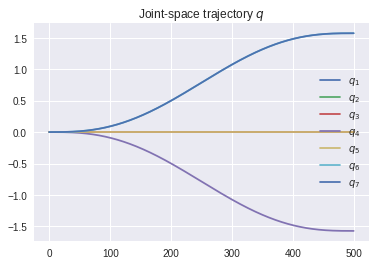

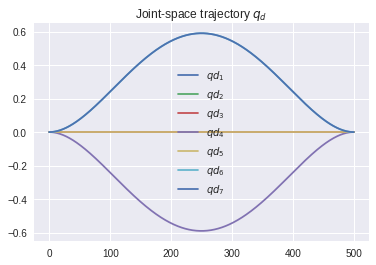

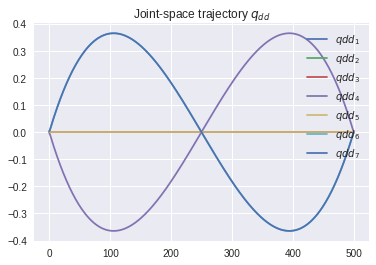

In [3]:
plt.plot(J1.T)
plt.title("Joint-space trajectory $q$")
plt.legend(['$q_1$', '$q_2$', '$q_3$', '$q_4$','$q_5$', '$q_6$', '$q_7$'])
plt.show()




plt.plot(Jd1.T)
plt.title("Joint-space trajectory $q_d$")
plt.legend(['$qd_1$', '$qd_2$', '$qd_3$', '$qd_4$','$qd_5$', '$qd_6$', '$qd_7$'])
plt.show()


plt.plot(Jdd1.T)
plt.title("Joint-space trajectory $q_{dd}$")
plt.legend(['$qdd_1$', '$qdd_2$', '$qdd_3$', '$qdd_4$','$qdd_5$', '$qdd_6$', '$qdd_7$'])
plt.show()

In [4]:
print Xd1.shape

(6, 500)


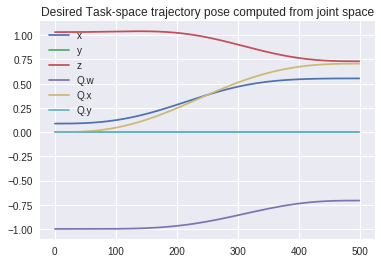

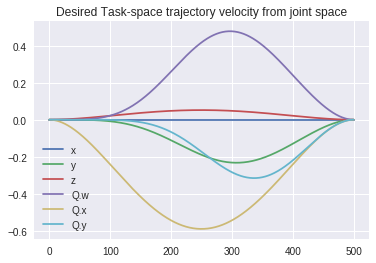

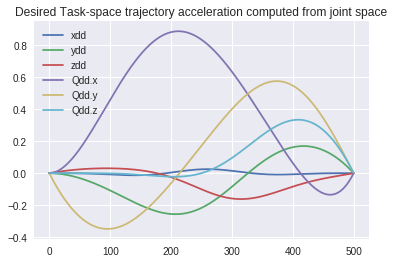

In [5]:
plt.plot(X1.T)
plt.legend(['x', 'y', 'z','Q.w', 'Q.x', 'Q.y', 'Q.z'])
plt.title('Desired Task-space trajectory pose computed from joint space')
plt.show()

plt.plot(Xd1.T)
plt.legend(['x', 'y', 'z','Q.w', 'Q.x', 'Q.y', 'Q.z'])
plt.title('Desired Task-space trajectory velocity from joint space')
plt.show()

plt.plot(Xdd1.T)
plt.legend(['xdd', 'ydd', 'zdd', 'Qdd.x', 'Qdd.y', 'Qdd.z'])
plt.title('Desired Task-space trajectory acceleration computed from joint space')
plt.show()



In [6]:

# F = np.array([0,0,0])
impctrl = impedanceController()
kx = 300.0
ky = 300.0
kz = 300.0
kr = 3.0
kp = 3.0
kya = 3.0

mx = 2.5
my = 2.5
mz = 2.5
mr = 0.3
mp = 0.3
mya = 0.3

impctrl.Kd = np.diag(np.array([kx,ky,kz, kr, kp, kya]))
impctrl.Md = np.diag(np.array([mx, my, mz, mr, mp, mya]))
# impctrl.Bd = np.diag( 2 * np.array([2*np.sqrt(kx/mx), 2*np.sqrt(ky/my), 2*np.sqrt(kz/mz),
#                                 2*np.sqrt(kr/mr), 2*np.sqrt(kp/mp), 2*np.sqrt(kya/mya)]))
impctrl.Bd = np.diag( np.array([2*np.sqrt(kx), 2*np.sqrt(ky), 2*np.sqrt(kz),
                                2*np.sqrt(kr), 2*np.sqrt(kp), 2*np.sqrt(kya)]))
# impctrl.Bd = np.diag(np.array([320,320,320,320,320,320]))
# impctrl.Bd = np.diag(np.array([320,320,320,320,320,320]))
impctrl.nullspace_stiffness_ = 300
impctrl.F = np.array([0,0,0,0,0,0])

print kx

print mx

print np.diag(np.array([np.sqrt(kx/mx),np.sqrt(ky/my),np.sqrt(kz/mz),
                                np.sqrt(kr/mr),np.sqrt(kp/mp),np.sqrt(kya/mya)]))


print np.diag(np.array([2*np.sqrt(kx/mx),2*np.sqrt(ky/my),2*np.sqrt(kz/mz),
                                2*np.sqrt(kr/mr),2*np.sqrt(kp/mp),2*np.sqrt(kya/mya)]))


print np.diag(np.array([2*np.sqrt(kx/mx),2*np.sqrt(ky/my),2*np.sqrt(kz/mz),
                                2*np.sqrt(kr/mr),2*np.sqrt(kp/mp),2*np.sqrt(kya/mya)]))

300.0
2.5
[[10.95445115  0.          0.          0.          0.          0.        ]
 [ 0.         10.95445115  0.          0.          0.          0.        ]
 [ 0.          0.         10.95445115  0.          0.          0.        ]
 [ 0.          0.          0.          3.16227766  0.          0.        ]
 [ 0.          0.          0.          0.          3.16227766  0.        ]
 [ 0.          0.          0.          0.          0.          3.16227766]]
[[21.9089023   0.          0.          0.          0.          0.        ]
 [ 0.         21.9089023   0.          0.          0.          0.        ]
 [ 0.          0.         21.9089023   0.          0.          0.        ]
 [ 0.          0.          0.          6.32455532  0.          0.        ]
 [ 0.          0.          0.          0.          6.32455532  0.        ]
 [ 0.          0.          0.          0.          0.          6.32455532]]
[[21.9089023   0.          0.          0.          0.          0.        ]
 [ 0.        

In [7]:
# For post trajectory control - to see whether the robot maintains the target position.
sampcol = trj.samples
samples = trj.samples
dx = trj.dx

data = dataCollect(sampcol)

# Initial parameters for the impedance controller.
# The cartesian parameter values:
Xf = X1[:,0]
Xfd = Xd1[:,0]
quatf = quaternion.from_float_array(Q1[:,0])
quatf_d = quaternion.from_float_array(Qd1[:,0])

end_effector_state = stateVector()
end_effector_state.x = Xf
end_effector_state.xd = Xfd
end_effector_state.quat = quatf
end_effector_state.quat_d = quatf_d

# The joint parameter values:
q = np.array([0, 0, 0, 0, 0, 0, 0])
# q = np.array([0.1, 0.1, 0.1, -np.pi/3, 0.1, np.pi/3, np.pi/3])
qd = np.array([0, 0, 0, 0, 0, 0, 0])
qdd = np.array([0, 0, 0, 0, 0, 0, 0])
jointState = jointStateVector(q, qd, qdd)

desired_state = stateVector()
desired_state.x = X1[:,0]
desired_state.xd = Xd1[:,0]
desired_state.xdd = Xdd1[:,0]
desired_state.quat = quaternion.from_float_array(Q1[:,0])
desired_state.quat_d = quaternion.from_float_array(Qd1[:,0])
desired_state.quat_dd = quaternion.from_float_array(Qdd1[:,0])

errorState = stateVector()
sim = simulation(desired_state, end_effector_state, jointState, errorState, data)

F = np.array([0,0,0,0,0,0])
start = time.time()
# The simulation loop.
for i in range(sampcol):
    if i > (samples-1):
#         sim.state_des.x = X1[:,i]
#         sim.state_des.xd = Xd1[:,i]
#         sim.state_des.xdd = Xdd1[:,i]
#         sim.state_des.quat = quaternion.slerp_evaluate(trj.q1et, trj.q2et, 1)
#         sim.state_des.quat_d = sim.state_des.quat * np.log(trj.q2et * trj.q1et.inverse())
#         sim.state_des.quat_dd = sim.state_des.quat * np.log(trj.q2et * trj.q1et.inverse())**2
#     elif i > (sampcol-1):
        sim.state_des.x = X1[:,samples-1]
        sim.state_des.xd = Xd1[:,samples-1]
        sim.state_des.xdd = Xdd1[:,samples-1]
        sim.state_des.quat = quaternion.from_float_array(Q1[:,samples-1])
        sim.state_des.quat_d = quaternion.from_float_array(Qd1[:,samples-1])
        sim.state_des.quat_dd = quaternion.from_float_array(Qdd1[:,samples-1])
        sim.jointState.qnull = J1[:,samples-1]
    else:
        sim.state_des.x = X1[:,i]
        sim.state_des.xd = Xd1[:,i]
        sim.state_des.xdd = Xdd1[:,i]
        sim.state_des.quat = quaternion.from_float_array(Q1[:,i])
        sim.state_des.quat_d = quaternion.from_float_array(Qd1[:,i])
        sim.state_des.quat_dd = quaternion.from_float_array(Qdd1[:,i])
        sim.jointState.qnull = J1[:,i]
        
#     if (i > 200) and (i < 300):
#         impctrl.F = np.array([0,0,0,0,0,0])
#     else:
#         impctrl.F = np.array([0,0,0,0,0,0])
    
    # Error signal    
    sim.feedbackError3(Waifu, 'quaternion')
    
    # Inverse Dynamics
#     tau = sim.classical_impedance_control(impctrl, Waifu, 7, 'quaternion')
#     sim.jointState.qnull = sim.jointState.q
    tau = sim.spong_impedance_control(impctrl, Waifu)
    
    data.tau[:,i] = tau
    
    # Acceleration from forward dynamics:
    qacc = Waifu.forwardDynamics(tau, sim.jointState.q, sim.jointState.qd, Waifu.grav)
    sim.data.aq[:,i] = qacc
    
    sim.qIntegrate(qacc, dx)
    sim.outputEndeffector(Waifu, 'quaternion')
    
    # Collecting output.
    sim.data.x[:,i] = sim.state_end.x
    sim.data.xd[:,i] = sim.state_end.xd
    sim.data.error[:,i] = sim.error.x
    
    print "line i: ", i

print("Done!")
end = time.time()
print(end - start)

Fx1 = plt.axes(projection='3d')

Fx1.plot3D( sim.data.x[0,:].T, sim.data.x[1,:].T, sim.data.x[2,:].T)
Fx1.plot3D(X1[0,:].T, X1[1,:].T, X1[2,:].T, linestyle='--')
plt.show()

plt.plot(X1[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()


plt.plot(X1[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

In [8]:
plt.rcParams['figure.figsize'] = [20, 12.5]
Fx1 = plt.axes(projection='3d')

Fx1.plot3D(sim.data.x[0,:].T,sim.data.x[1,:].T,sim.data.x[2,:].T)
Fx1.plot3D(X1[0,:].T, X1[1,:].T, X1[2,:].T, linestyle='--')
Fx1.set(xlim=(-1.5, 1.8), ylim=(-1.5, 1.8))
plt.show()

plt.plot(X1[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(X1[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.xd[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

line i:  0
line i:  1
line i:  2
line i:  3
line i:  4
line i:  5
line i:  6
line i:  7
line i:  8
line i:  9
line i:  10
line i:  11
line i:  12
line i:  13
line i:  14
line i:  15
line i:  16
line i:  17
line i:  18
line i:  19
line i:  20
line i:  21
line i:  22
line i:  23
line i:  24
line i:  25
line i:  26
line i:  27
line i:  28
line i:  29
line i:  30
line i:  31
line i:  32
line i:  33
line i:  34
line i:  35
line i:  36
line i:  37
line i:  38
line i:  39
line i:  40
line i:  41
line i:  42
line i:  43
line i:  44
line i:  45
line i:  46
line i:  47
line i:  48
line i:  49
line i:  50
line i:  51
line i:  52
line i:  53
line i:  54
line i:  55
line i:  56
line i:  57
line i:  58
line i:  59
line i:  60
line i:  61
line i:  62
line i:  63
line i:  64
line i:  65
line i:  66
line i:  67
line i:  68
line i:  69
line i:  70
line i:  71
line i:  72
line i:  73
line i:  74
line i:  75
line i:  76
line i:  77
line i:  78
line i:  79
line i:  80
line i:  81
line i:  82
line i:  83
li

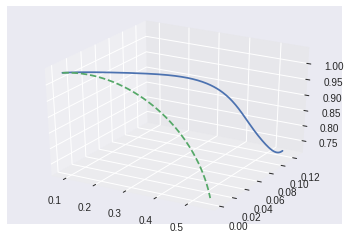

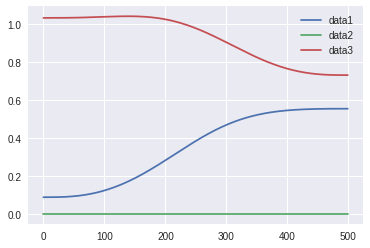

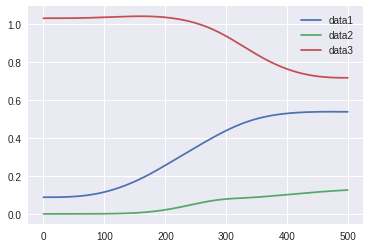

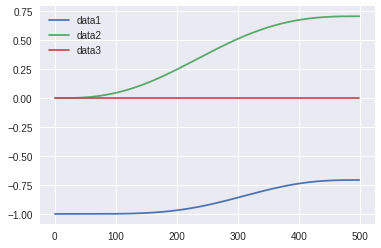

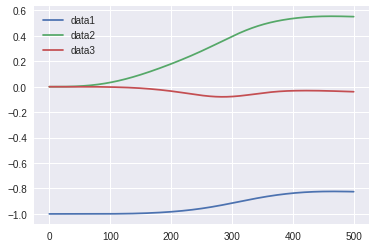

In [9]:
# For post trajectory control - to see whether the robot maintains the target position.
sampcol = trj.samples
samples = trj.samples
dx = trj.dx

data = dataCollect(sampcol)

# Initial parameters for the impedance controller.
# The cartesian parameter values:
Xf = X1[:,0]
Xfd = Xd1[:,0]
quatf = quaternion.from_float_array(Q1[:,0])
# quatf_d = quaternion.from_float_array(Qd1[:,0])

end_effector_state = stateVector()
end_effector_state.x = Xf
end_effector_state.xd = Xfd
end_effector_state.quat = quatf
# end_effector_state.quat_d = quatf_d

# The joint parameter values:
q = np.array([0, 0, 0, 0, 0, 0, 0])
qd = np.array([0, 0, 0, 0, 0, 0, 0])
qdd = np.array([0, 0, 0, 0, 0, 0, 0])
jointState = jointStateVector(q, qd, qdd)

desired_state = stateVector()
desired_state.x = X1[:,0]
desired_state.xd = Xd1[:,0]
desired_state.xdd = Xdd1[:,0]
desired_state.quat = quaternion.from_float_array(Q1[:,0])
# desired_state.quat_d = quaternion.from_float_array(Qd1[:,0])
# desired_state.quat_dd = quaternion.from_float_array(Qdd1[:,0])

errorState = stateVector()
sim = simulation(desired_state, end_effector_state, jointState, errorState, data)

impctrl.zeta = np.array([1, 1, 1, 1, 1, 1])

M = Waifu.inertiaComp(np.array([0, 0, 0, -np.pi/2, 0, np.pi/2, np.pi/2]))
Ns = impctrl.nullspace_stiffness_
impctrl.Bd, Kd_rand = impctrl.damping_dual_eigen(impctrl.Kd,impctrl.Md)

sim.Kn = np.diag(np.array([Ns,Ns,Ns,Ns,Ns,Ns,Ns]))
sim.Bn, Kd_b3 = impctrl.damping_dual_eigen2(sim.Kn, M)

F = np.array([0,0,0,0,0,0])
start = time.time()
# The simulation loop.
for i in range(sampcol):
    if i > (samples-1):
        sim.state_des.x = X1[:,samples-1]
        sim.state_des.xd = Xd1[:,samples-1]
        sim.state_des.xdd = Xdd1[:,samples-1]
        sim.state_des.quat = quaternion.from_float_array(Q1[:,samples-1])
        sim.jointState.qnull = J1[:,samples-1]
    else:
        sim.state_des.x = X1[:,i]
        sim.state_des.xd = Xd1[:,i]
        sim.state_des.xdd = Xdd1[:,i]
        sim.state_des.quat = quaternion.from_float_array(Q1[:,i])
        sim.jointState.qnull = J1[:,i]
        sim.jointState.qdnull = Jd1[:,i]
        sim.jointState.qddnull = Jdd1[:,i]
        
#     if (i > 300) and (i < 310):
#         impctrl.F = np.array([50,0,0,0,0,0])
#     else:
#         impctrl.F = np.array([0,0,0,0,0,0])
    
    # Error signal    
    sim.feedbackError3(Waifu, 'quaternion')
    
    # Inverse Dynamics
#     tau = sim.classical_impedance_control(impctrl, Waifu, 7, 'quaternion')
    tau = sim.spong_impedance_control(impctrl, Waifu)
    sim.data.tau[:,i] = tau
    
    # Acceleration from forward dynamics:
    qacc = Waifu.forwardDynamics(tau, sim.jointState.q, sim.jointState.qd, Waifu.grav)
    sim.data.aq[:,i] = qacc
    
    sim.qIntegrate(qacc, dx)
    sim.outputEndeffector(Waifu, 'quaternion')
    
    # Collecting output.
    sim.data.x[:,i] = sim.state_end.x
    sim.data.xd[:,i] = sim.state_end.xd
    sim.data.error[:,i] = sim.error.x
    
    print "line i: ", i

print("Done!")
end = time.time()
print(end - start)

Fx1 = plt.axes(projection='3d')

Fx1.plot3D( sim.data.x[0,:].T, sim.data.x[1,:].T, sim.data.x[2,:].T)
Fx1.plot3D(X1[0,:].T, X1[1,:].T, X1[2,:].T, linestyle='--')
plt.show()

plt.plot(X1[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()


plt.plot(X1[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

[ 1.29389302e-03 -3.30916406e-03  2.31867862e-01 -1.58184243e+00
 -2.19751301e-01  1.45882212e+00  1.39901366e+00]


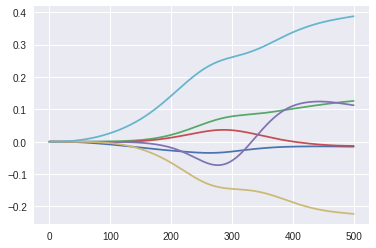

In [10]:
print sim.jointState.q
plt.plot(sim.data.error.T)
plt.show()

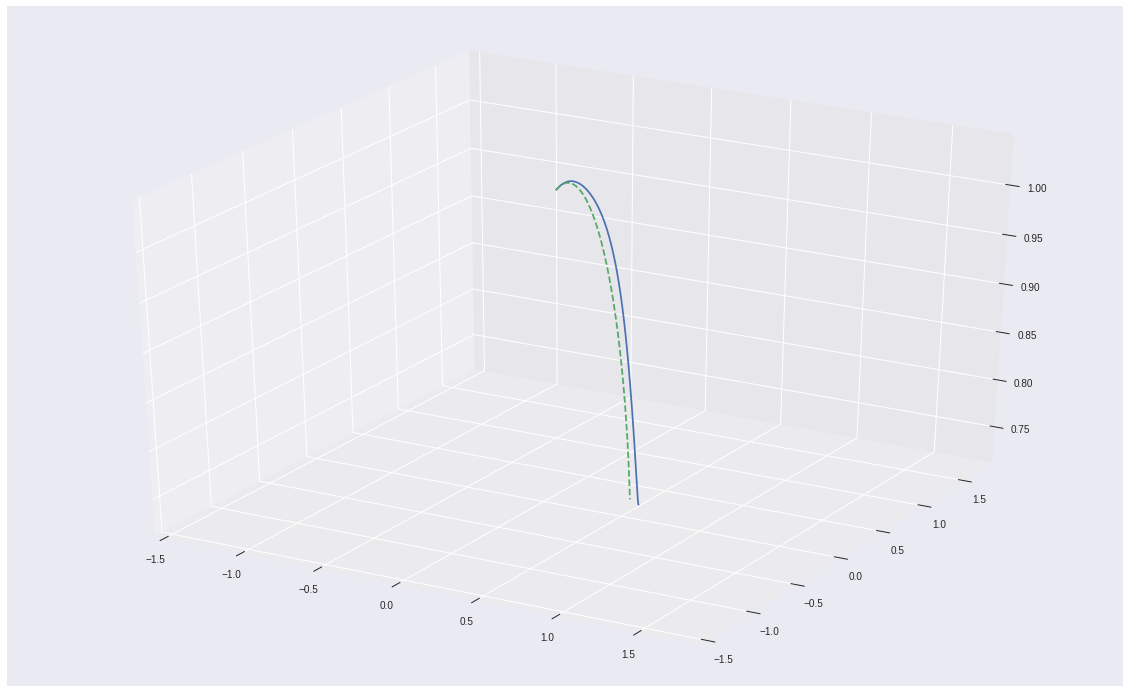

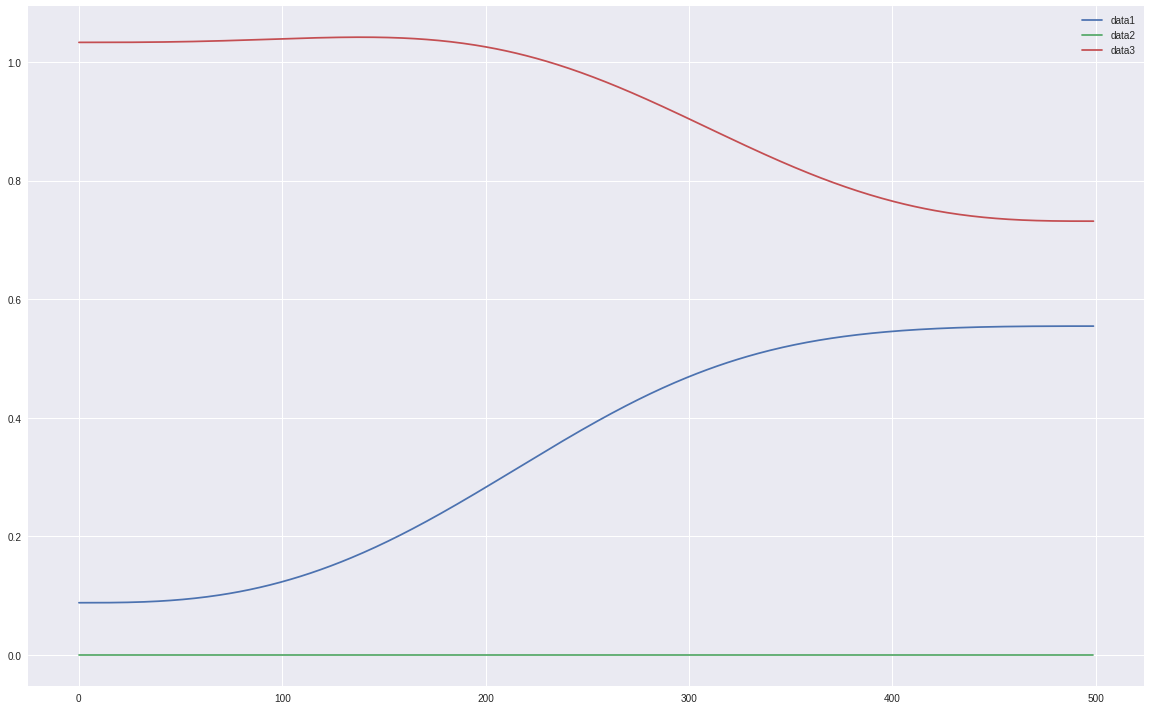

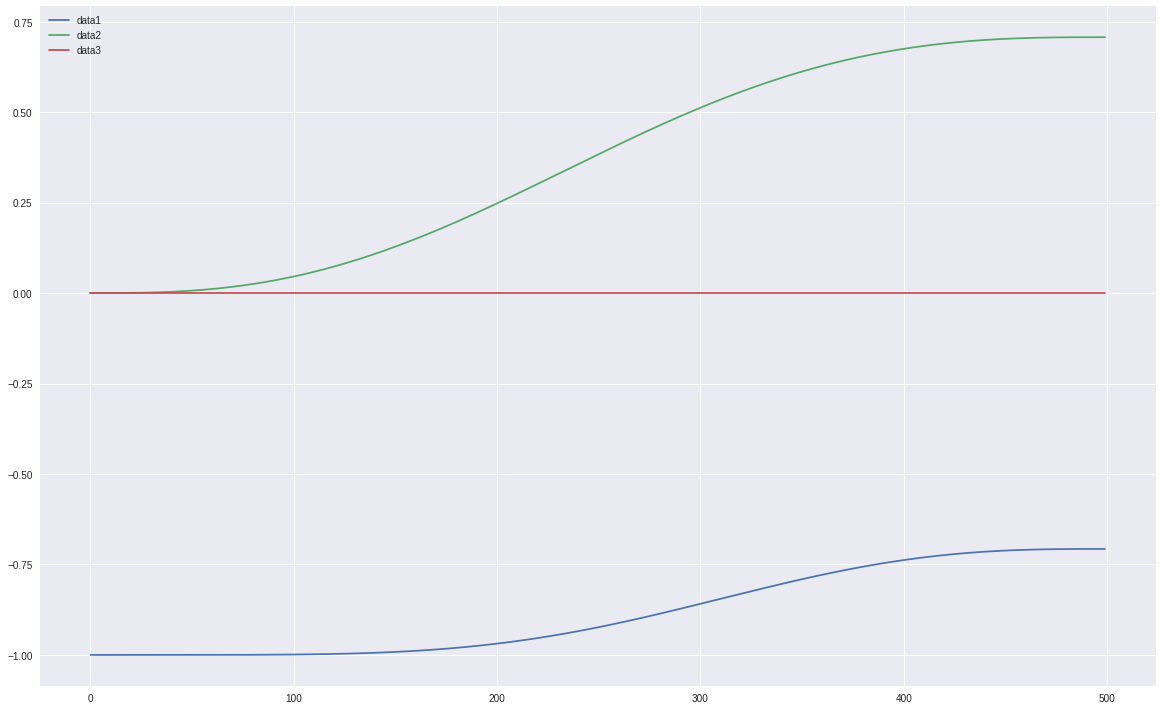

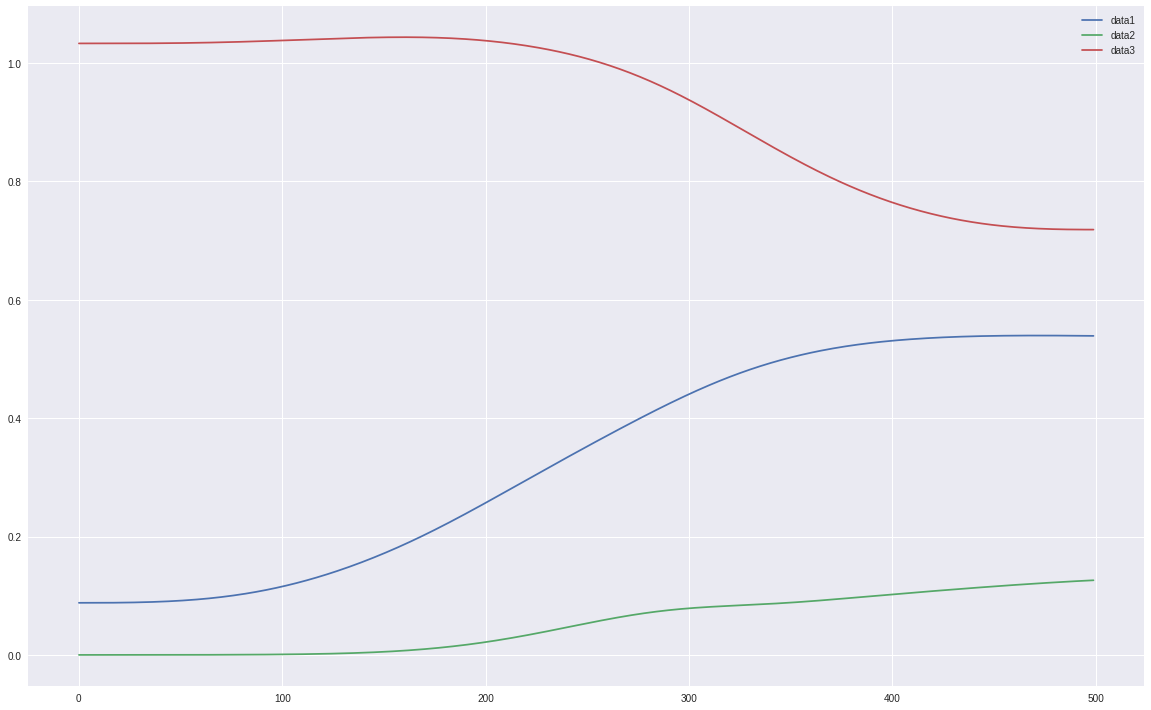

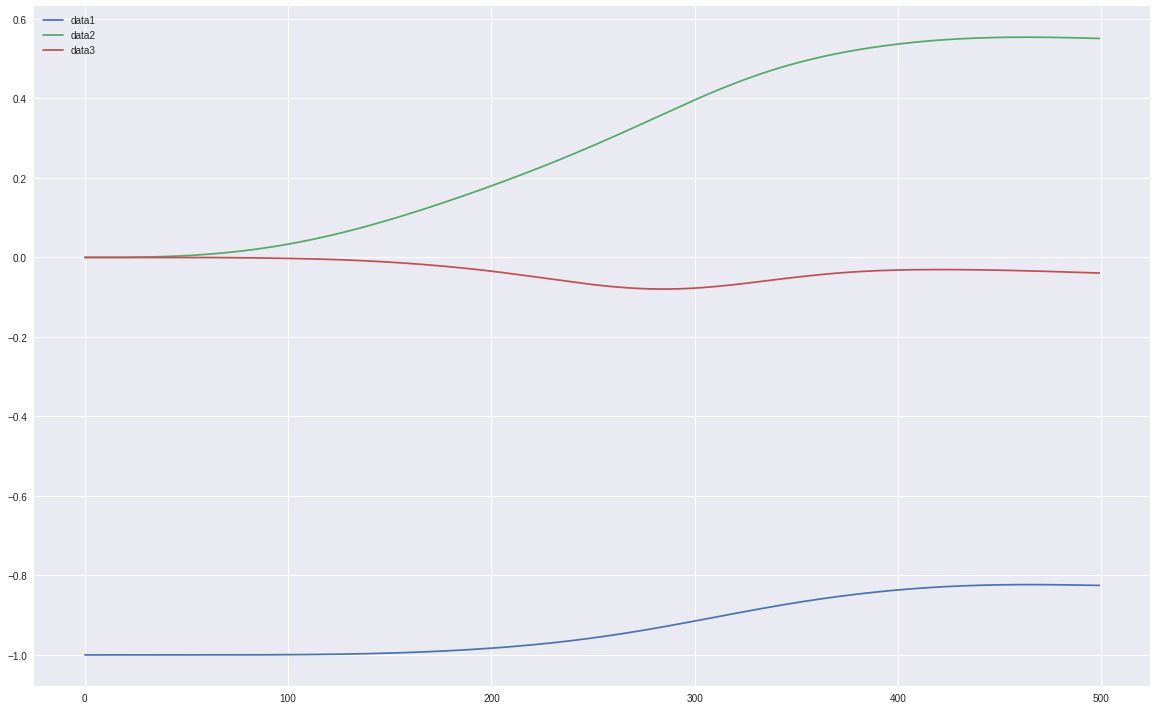

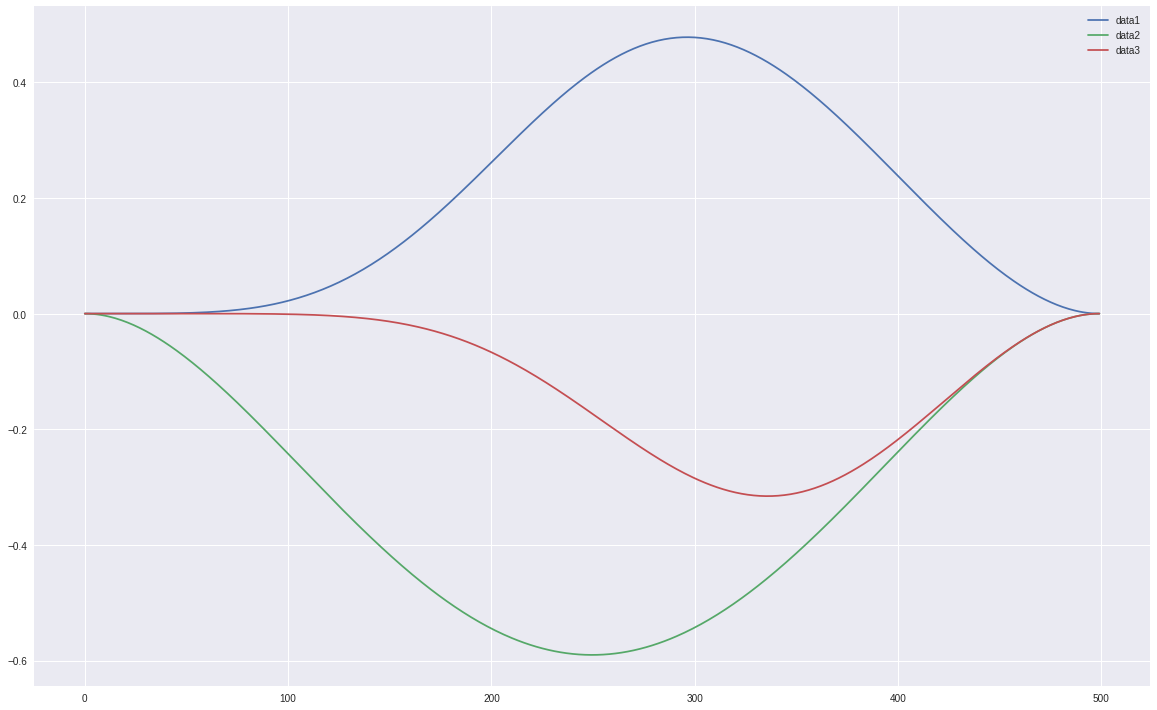

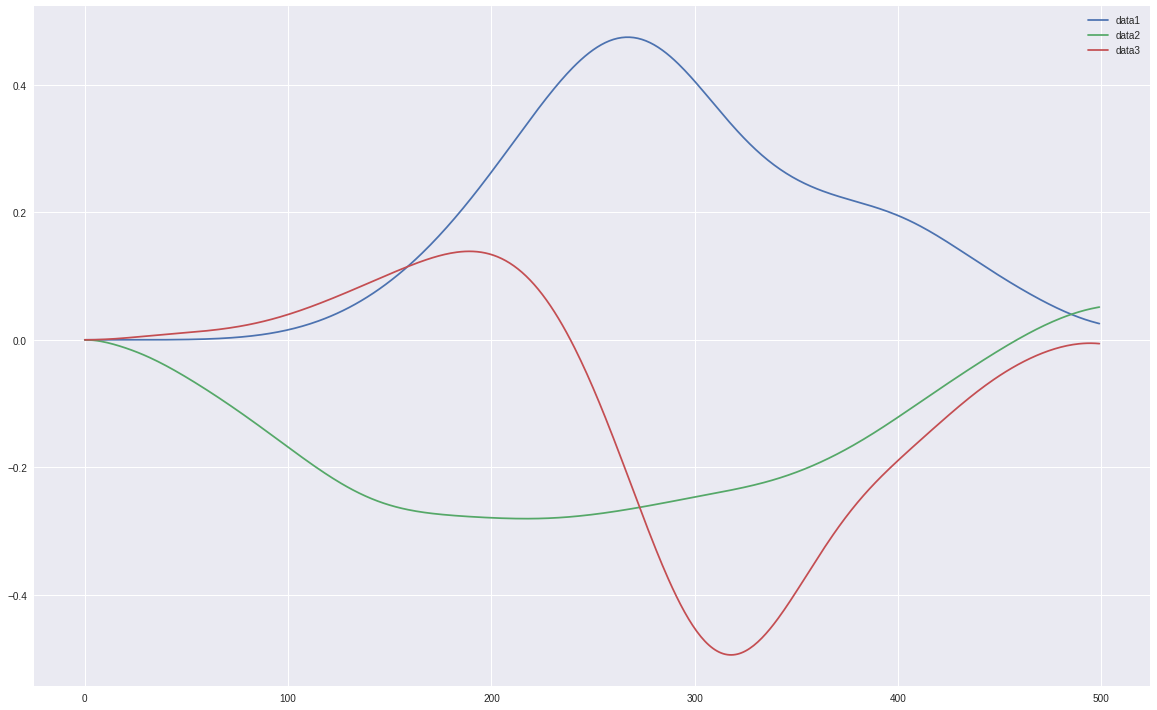

In [11]:
plt.rcParams['figure.figsize'] = [20, 12.5]
Fx1 = plt.axes(projection='3d')

Fx1.plot3D(sim.data.x[0,:].T,sim.data.x[1,:].T,sim.data.x[2,:].T)
Fx1.plot3D(X1[0,:].T, X1[1,:].T, X1[2,:].T, linestyle='--')
Fx1.set(xlim=(-1.5, 1.8), ylim=(-1.5, 1.8))
plt.show()

plt.plot(X1[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(X1[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(Xd1[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()


plt.plot(sim.data.xd[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

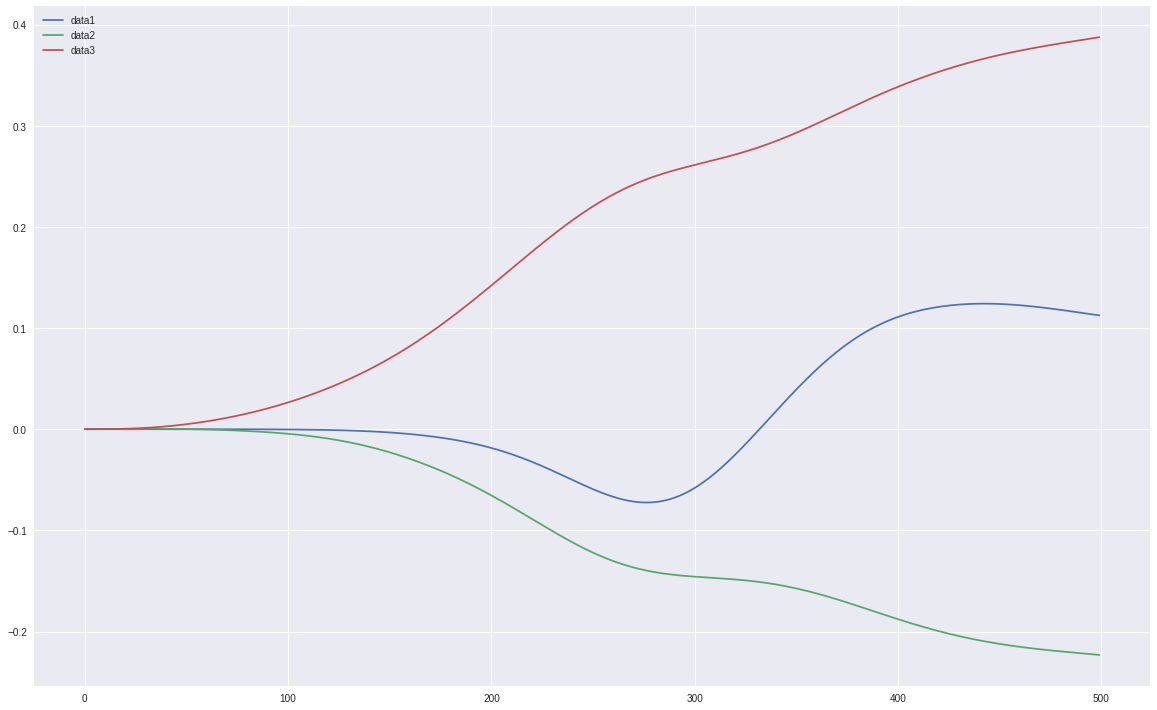

In [12]:
plt.plot(sim.data.error[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

# Equilibrium Test:
--------------------------------
The following is an implementation of the control strategy created by the developers of franka emika panda. The goal is to replicate the experiment as best as possible.


In [13]:
# For post trajectory control - to see whether the robot maintains the target position.
sampcol = trj.samples+100
samples = trj.samples
dx = trj.dx
impctrl.nullspace_stiffness_ = 50
data = dataCollect(sampcol)

# Initial parameters for the impedance controller.
# The cartesian parameter values:
Xf = X1[:,0]
Xfd = Xd1[:,0]
quatf = trj.q1et
quatf_d = trj.quatf * np.log(trj.q2et * trj.q1et.inverse())

end_effector_state = stateVector()
end_effector_state.x = Xf
end_effector_state.xd = Xfd
end_effector_state.quat = quatf
end_effector_state.quat_d = quatf_d

# The joint parameter values:
q = np.array([0, 0, 0, 0, 0, 0, 0])
qd = np.array([0, 0, 0, 0, 0, 0, 0])
qdd = np.array([0, 0, 0, 0, 0, 0, 0])
jointState = jointStateVector(q, qd, qdd)

desired_state = stateVector()
desired_state.x = X1[:,0]
desired_state.xd = Xd1[:,0]
desired_state.xdd = Xdd1[:,0]
desired_state.quat = quaternion.slerp_evaluate(trj.q1et, trj.q2et, trj.it[0])
desired_state.quat_d = desired_state.quat * np.log(trj.q2et * trj.q1et.inverse())
desired_state.quat_dd = desired_state.quat * np.log(trj.q2et * trj.q1et.inverse())**2

errorState = stateVector()
sim = simulation(desired_state, end_effector_state, jointState, errorState, data)

F = np.array([0,0,0,0,0,0])
start = time.time()
# The simulation loop.
impctrl.x = X1[:,0]
impctrl.x_target = X1[:,-1]
impctrl.quat = quaternion.slerp_evaluate(trj.q1et, trj.q2et, 0)
impctrl.quat_target = quaternion.slerp_evaluate(trj.q1et, trj.q2et, 1)
for i in range(sampcol):
    if (i > samples-1):
        sim.jointState.qnull = J1[:,samples-1]
    else:
        sim.jointState.qnull = J1[:,i]

    sim.state_des.x = impctrl.x
    sim.state_des.quat = impctrl.quat
        
    # Error signal    
    sim.feedback_equilibrium(Waifu)
    
    # Inverse Dynamics
    tau = sim.impedance_control_equilibrium(impctrl, Waifu, 6, 'quaternion')
    data.tau[:,i] = tau

    # Acceleration from forward dynamics:
    qacc = Waifu.forwardDynamics(tau, sim.jointState.q, sim.jointState.qd, Waifu.grav)
    sim.data.aq[:,i] = qacc
    
    sim.qIntegrate(qacc, dx)
    sim.output_equilibrium_update(Waifu)
    impctrl.exponential_smoothing()
    
    # Collecting output.
    sim.data.x[:,i] = sim.state_end.x
    sim.data.xd[:,i] = sim.state_end.xd
    sim.data.error[:,i] = sim.error.x

print("Done!")
end = time.time()
print(end - start)

Fx1 = plt.axes(projection='3d')

Fx1.plot3D( sim.data.x[0,:].T, sim.data.x[1,:].T, sim.data.x[2,:].T)
Fx1.plot3D(X1[0,:].T, X1[1,:].T, X1[2,:].T, linestyle='--')
plt.show()

plt.plot(X1[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[:3].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

plt.plot(sim.data.x[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

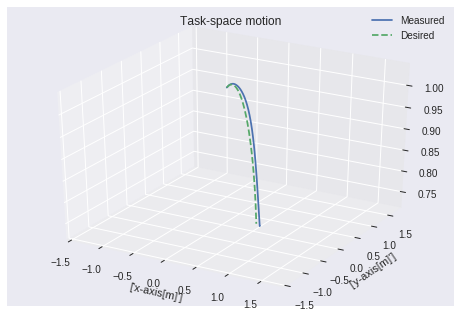

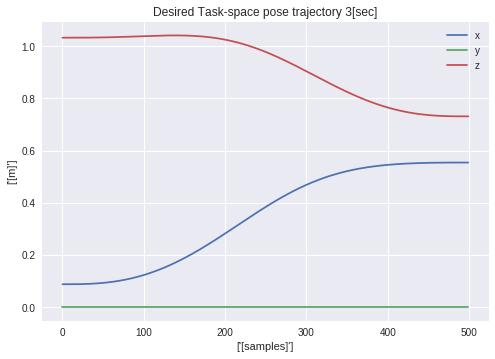

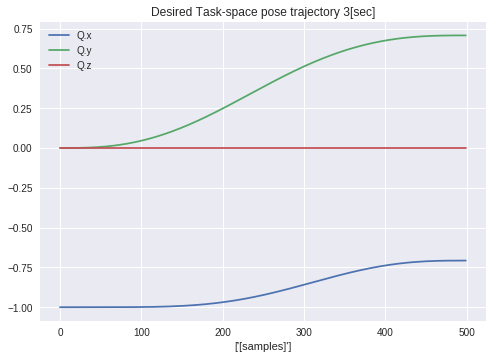

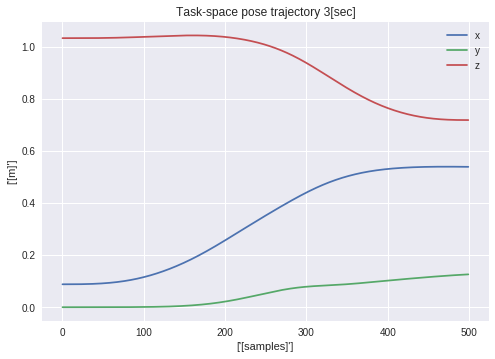

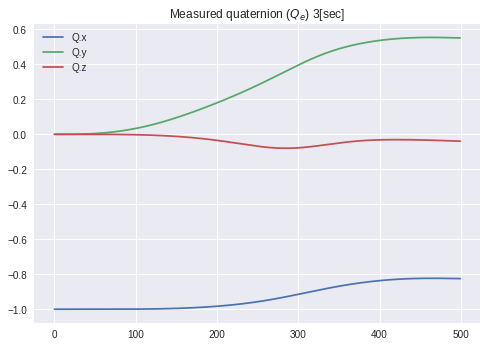

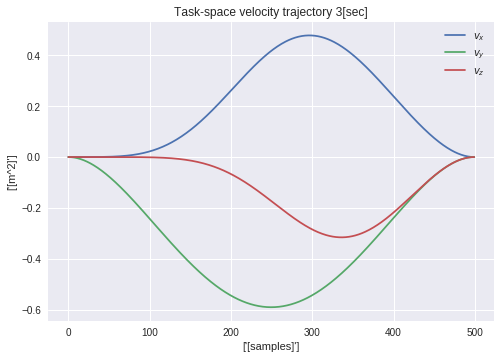

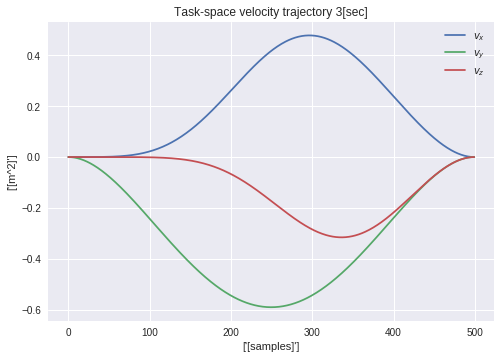

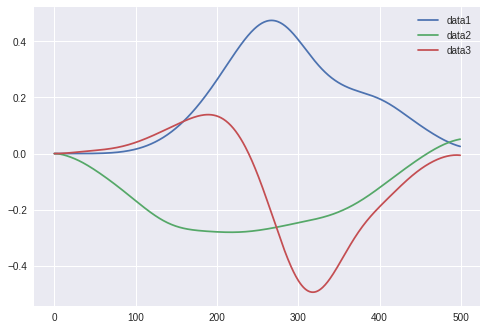

In [24]:
Fx1 = plt.axes(projection='3d')

Fx1.plot3D(sim.data.x[0,:].T,sim.data.x[1,:].T,sim.data.x[2,:].T)

Fx1.plot3D(X1[0,:].T, X1[1,:].T, X1[2,:].T, linestyle='--')
Fx1.set(xlim=(-1.5, 1.8), ylim=(-1.5, 1.8))
plt.legend(['Measured', 'Desired'])
plt.xlabel(['x-axis[m]'])
plt.ylabel(['y-axis[m]'])
plt.title('Task-space motion')
plt.show()

plt.plot(X1[:3].T)
plt.legend(['x', 'y', 'z'])
plt.title('Desired Task-space pose trajectory 3[sec]')
plt.xlabel(['[samples]'])
plt.ylabel(['[m]'])
plt.show()

plt.plot(X1[3:].T)
plt.legend(['Q.x', 'Q.y', 'Q.z'])
plt.title('Desired Task-space pose trajectory 3[sec]')
plt.xlabel(['[samples]'])
plt.show()

plt.plot(sim.data.x[:3].T)
plt.legend(['x', 'y', 'z'])
plt.title('Task-space pose trajectory 3[sec]')
plt.xlabel(['[samples]'])
plt.ylabel(['[m]'])
plt.show()

plt.plot(sim.data.x[3:].T)
plt.legend(['Q.x', 'Q.y', 'Q.z'])
plt.title('Measured quaternion ($Q_e$) 3[sec]')
plt.show()

plt.plot(Xd1[3:].T)
plt.legend(['$v_x$', '$v_y$', '$v_z$'])
plt.title('Task-space velocity trajectory 3[sec]')
plt.xlabel(['[samples]'])
plt.ylabel(['[m^2]'])
plt.show()

plt.plot(Xd1[3:].T)
plt.legend(['$v_x$', '$v_y$', '$v_z$'])
plt.title('Task-space velocity trajectory 3[sec]')
plt.xlabel(['[samples]'])
plt.ylabel(['[m^2]'])
plt.show()

plt.plot(sim.data.xd[3:].T)
plt.legend(['data1', 'data2', 'data3'])
plt.show()

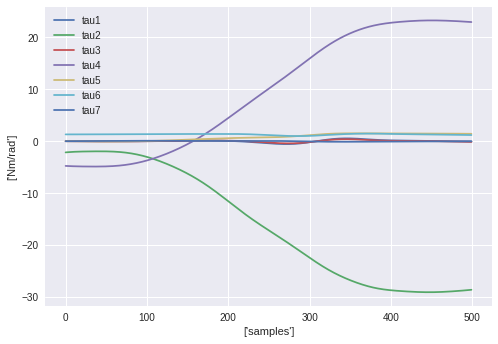

In [27]:
plt.plot(sim.data.tau.T)
plt.legend(['tau1', 'tau2', 'tau3','tau4', 'tau5', 'tau6', 'tau7'])
plt.xlabel(['samples'])
plt.ylabel(['Nm/rad'])
plt.show()

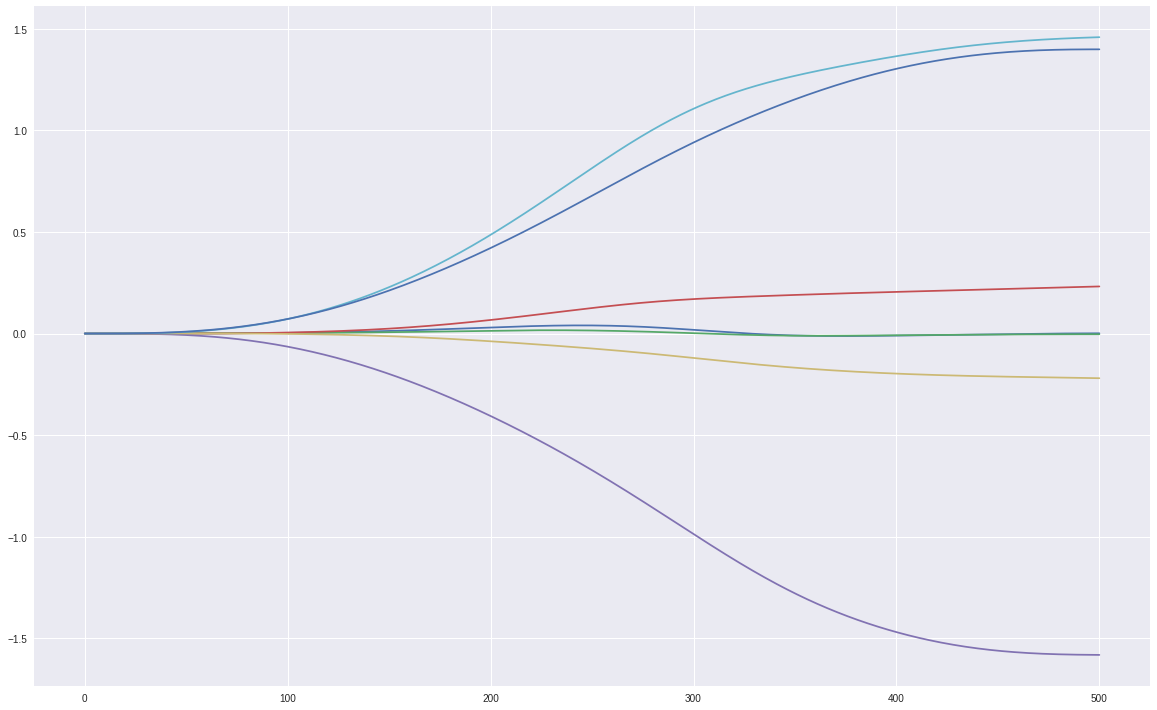

In [16]:
plt.plot(sim.data.q.T)
plt.show()